In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py
from copy import deepcopy

lam1.25/small_cells/SD/dphi0.1/Nbar100
lam1.25/small_cells/SA/dphi0.1/Nbar100
lam1.25/small_cells/SD/dphi0.49/Nbar100
lam1.25/small_cells/SA/dphi0.49/Nbar100
lam0.25/small_cells/SD/dphi0.49/Nbar100
lam0.25/small_cells/SA/dphi0.49/Nbar100


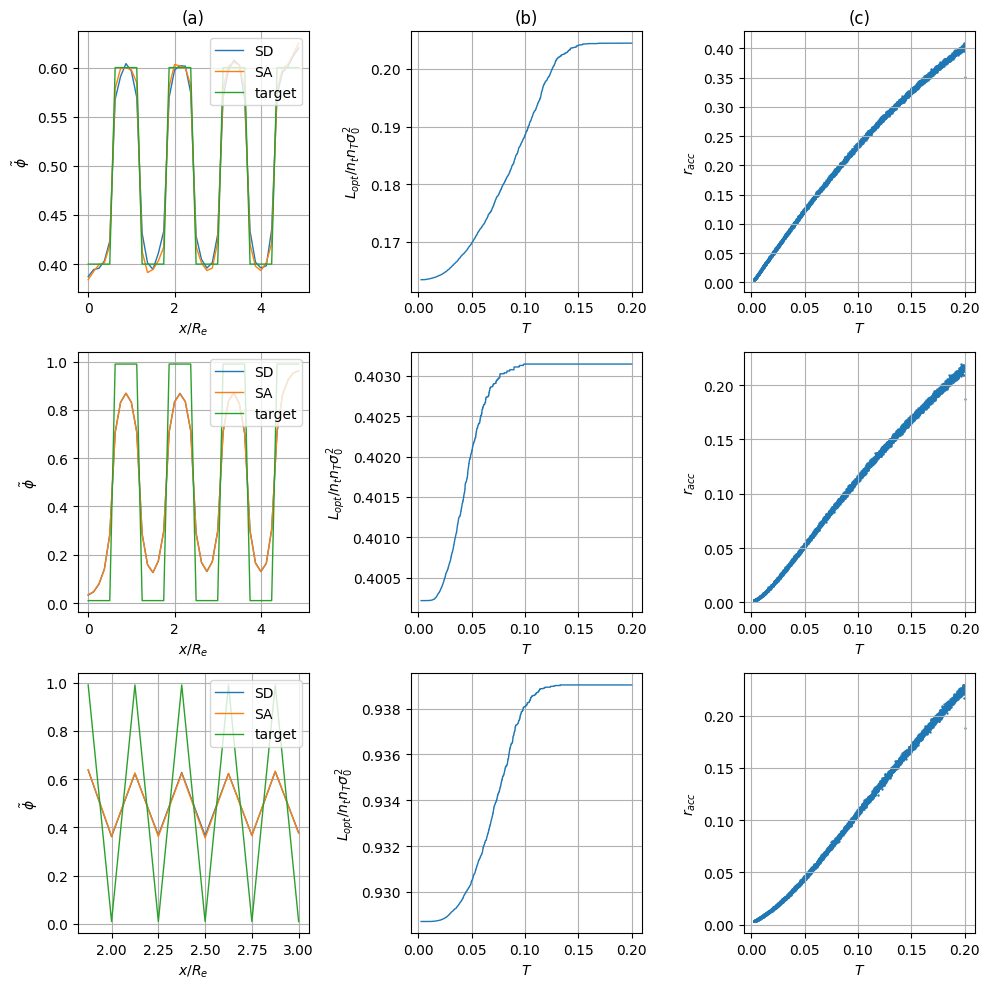

In [2]:


#dphis=[0,0.1,0.2,0.3,0.4,0.5]
#dphis=[0.2,0.3,0.4,0.49]
dirs=["lam_0.","SD"]
Nbar=100
offset=1
fig, axs = plt.subplots(3, 3, figsize=(10, 10),dpi=100)


def plot_stuff(i,axs,lam,alg,dphi):
    """Function to plot Amplitude, L-T plot and acceptance rate
    """
    dir=f"lam{lam}/small_cells/{alg}/dphi{dphi}/Nbar{Nbar}"
    print(dir)
    with h5py.File(f'{dir}/coord.h5', 'r') as f:
        ##number of beads per polymer
        N=int(f['parameter/reference_Nbeads'][()]) 
        #kappa
        kappa=30/N
        ##number of polymers
        n_polym=int(f['parameter/n_polymers'][()]) 
        n_poly_type=int(f['parameter/n_poly_type'][()]) 
        n_types=int(f['parameter/n_types'][()]) 
        ##box dimensions 
        lxyz=np.array(f['parameter/lxyz'])
        ##box discretization
        nxyz=np.array(f['parameter/nxyz'])
        #discretization
        dxyz=lxyz/nxyz
        #adjust lengths and discretizations
        lxyz=lxyz-2*offset*dxyz
        nxyz=nxyz-2*offset
        #umbrella field
        umb_field=np.array(f["umbrella_field"])
        #area51
        area51=np.array(f["area51"])
        with h5py.File(f'{dir}/coord_ana.h5', 'r') as f:
            #only load every other frame, the others are not optimized
            phi=np.array(f['density_field'])
    #simulation time in MCS
    t =len(phi)
    #only every other frame is optimized
    phi=phi[1::2]
    #average phi over time
    phi=phi.mean(axis=0)
    #cell volume
    V_cell=np.prod(dxyz)
    #number of accessible cells 
    n_cells=int(len(area51[area51==0]))
    #number of target cells
    n_cells_target=len(umb_field[umb_field>-1])
    #field scaling type
    scale=n_cells/(N*n_polym)
    #reshape density and umbrella field
    phi=phi*scale
    phi=phi[:,area51==0].reshape(phi.shape[0],nxyz[0],nxyz[1],nxyz[2])
    phi_tot=np.sum(phi,axis=0)
    #phi_tot[phi_tot==0]=1
    umb_field=umb_field[umb_field>-1].reshape(2,nxyz[0],nxyz[2])
    composition=deepcopy(phi)
    for j in range(2):
        composition[j]/=phi_tot
    #get phi and composition at y value where umbrella field is defined averaged over z
    phi_mean=phi[:,:,0,:].mean(axis=2)
    composition_mean=composition[:,:,0,:].mean(axis=2)
    #volume
    V=V_cell*n_cells
    #average bead density
    rho0=N*Nbar
    #beads per cell
    rhoc=rho0*V_cell 
    #natural density fluctuations
    var_phi=1/(rho0*kappa*V_cell) 
    l_plot=np.arange(0,lxyz[0],dxyz[0])
    if(lam==1.25):
        axs[i,0].plot(l_plot,composition_mean[0],lw=1,label=alg)
    else:
        mid=len(l_plot)//2
        axs[i,0].plot(l_plot[int(mid-mid/4): int(mid+mid/4) ],composition_mean[0][int(mid-mid/4): int(mid+mid/4) ],lw=1,label=alg)
    if(alg=="SA"):
        T=np.loadtxt(f"{dir}/T.csv")
        T=T[:T.shape[0]//2]
        n_T=len(T)#number of temperatures
        opt=np.loadtxt(f"{dir}/opt.csv")/n_cells_target
        opt=opt.reshape(t,int(opt.shape[0]/t))[1::2]
        opt_mean=opt.mean(axis=0)
        opt_mean=opt_mean.reshape(n_T,int(opt_mean.shape[0]/n_T))
        acc_rate=np.loadtxt(f"{dir}/acc_rate.csv")#/n_cells_target
        acc_rate=acc_rate.reshape(t,int(acc_rate.shape[0]/t))[1::2].mean(axis=0)
        acc_rate=acc_rate.reshape(n_T,int(acc_rate.shape[0]/n_T))
        if(lam==1.25):
            axs[i,0].plot(l_plot,umb_field[0,:,0],lw=1,label="target")
        else:
            mid=len(l_plot)//2
            axs[i,0].plot(l_plot[int(mid-mid/4): int(mid+mid/4) ],umb_field[0,:,0][int(mid-mid/4): int(mid+mid/4) ],lw=1,label="target")
        axs[i,1].plot(T,opt_mean/var_phi,lw=1)
        axs[i,2].scatter(T,acc_rate,s=0.5)
    axs[i,0].legend(loc='upper right')
    return

plot_stuff(0,axs,1.25,"SD",0.1)
plot_stuff(0,axs,1.25,"SA",0.1)
plot_stuff(1,axs,1.25,"SD",0.49)
plot_stuff(1,axs,1.25,"SA",0.49)
plot_stuff(2,axs,0.25,"SD",0.49)
plot_stuff(2,axs,0.25,"SA",0.49)
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].grid()

for i in range(axs.shape[0]):
    axs[i,0].set_xlabel("$x/R_e$")
    axs[i,0].set_ylabel(r"$\tilde\phi$")
    axs[i,1].set_ylabel("$L_{opt}/n_tn_T\sigma_0^2$")
    axs[i,2].set_ylabel("$r_{acc}$")
    
    for j in range(1,axs.shape[1]):
        axs[i,j].set_xlabel("$T$")

axs[0,0].set_title("(a)")
axs[0,1].set_title("(b)")
axs[0,2].set_title("(c)")
plt.tight_layout()
plt.savefig("comparison_sd_sa.pdf")




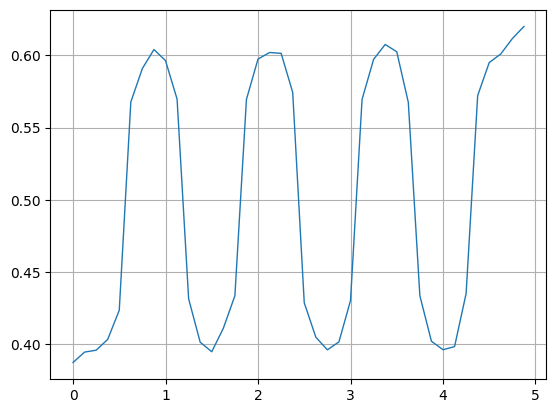

In [3]:


#dphis=[0,0.1,0.2,0.3,0.4,0.5]
#dphis=[0.2,0.3,0.4,0.49]
dirs=["lam_0.","SD"]
Nbar=100
offset=1


plt.figure(dpi=100)
plt.grid()
def plot_conversion_range(y,axs,lam,alg,dphi):
    """Function to plot Amplitude, L-T plot and acceptance rate
    """
    dir=f"lam{lam}/small_cells/{alg}/dphi{dphi}/Nbar{Nbar}"
    with h5py.File(f'{dir}/coord.h5', 'r') as f:
        ##number of beads per polymer
        N=int(f['parameter/reference_Nbeads'][()]) 
        #kappa
        kappa=30/N
        ##number of polymers
        n_polym=int(f['parameter/n_polymers'][()]) 
        n_poly_type=int(f['parameter/n_poly_type'][()]) 
        n_types=int(f['parameter/n_types'][()]) 
        ##box dimensions 
        lxyz=np.array(f['parameter/lxyz'])
        ##box discretization
        nxyz=np.array(f['parameter/nxyz'])
        #discretization
        dxyz=lxyz/nxyz
        #adjust lengths and discretizations
        lxyz=lxyz-2*offset*dxyz
        nxyz=nxyz-2*offset
        #umbrella field
        umb_field=np.array(f["umbrella_field"])
        #area51
        area51=np.array(f["area51"])
        with h5py.File(f'{dir}/coord_ana.h5', 'r') as f:
            #only load every other frame, the others are not optimized
            phi=np.array(f['density_field'])

    #only every other frame is optimized
    phi=phi[1::2]
    #average phi over time
    phi=phi.mean(axis=0)
    #number of accessible cells 
    n_cells=int(len(area51[area51==0]))
    #field scaling type
    scale=n_cells/(N*n_polym)
    #reshape density and umbrella field
    phi=phi*scale
    phi=phi[:,area51==0].reshape(phi.shape[0],nxyz[0],nxyz[1],nxyz[2])
    phi_tot=np.sum(phi,axis=0)
    #phi_tot[phi_tot==0]=1
    umb_field=umb_field[umb_field>-1].reshape(2,nxyz[0],nxyz[2])
    composition=deepcopy(phi)
    for j in range(2):
        composition[j]/=phi_tot
    #get phi and composition at y value where umbrella field is defined averaged over z
    composition_mean=composition[:,:,y,:].mean(axis=2)
    l_plot=np.arange(0,lxyz[0],dxyz[0])
    plt.plot(l_plot,composition_mean[0],lw=1,label=alg)
    return

plot_conversion_range(0,axs,1.25,"SD",0.1)
plt.show()




In [6]:
#number of flips
n_flips_sa=np.loadtxt("lam1.25/small_cells/sa/num_flips/dphi0.1/Nbar100/flips.csv")[1::2]
n_flips_sd=np.loadtxt("lam1.25/small_cells/sd/num_flips/dphi0.1/Nbar100/flips.csv")[1::2]
print(n_flips_sa)

[10412550. 10165734. 10296855. 10497393. 10489680. 10782774. 10158021.
 10427976. 10605375. 10312281. 10289142. 10188873.  9980622. 10150308.
 10443402. 10427976. 10212012. 10266003. 10481967.  9942057. 10435689.
 10366272. 10404837. 10566810. 10173447. 10420263. 10003761.]
